# <center> NPoS Economics <center>
####  <center> Eray Sabancilar, Web3 Foundation, January 15, 2020 <center> 

## Introduction
In this notebook, we provide a microeconomic model of the NPoS agents, namely, nominators and validators. We use the Kusama genesis balance data and various statistical models to simulate NPoS economics.

We want to answer the following questions (and more?) with the NPoS economic model:
1. Does staking rate, $x$, maintain a reasonable value, e.g., $x \sim 0.5$?
2. How do validator revenues evolve? Do they shrink to zero?
3. How do price stability (inflation), interest rate, supply & demand, and liquidity of dots evolve? 
4. How does the wealth distribution evolve? Do we expect accumulation of wealth to occur?
5. How can we achive validator decentralization given some operators may be running many validators nodes? Can we model correlations among validator nodes belonging to the same operators? How can we reduce slashing risks for nominators?
    - Consider modeling correlations among the validator nodes of the same operator high, whereas the validator nodes of different operators very small (or even zero) in order to capture possible effects of collective slashing on the network.
    - We can use a simple mean-variance optimization scheme for making nominators diversify their validator choices to boost decentralization, e.g., $L = v^T R - \frac{1}{2}v^T \Sigma v$, where $v$ is the validator choice vector, $R$ is the vector of returns on dots, and $\Sigma$ is the covariance matrix of validator nodes.
6.  How do we avoid high volatility in staking?

### Model Assumptions
1. Time is discrete, $t = 0,1,2,...$, all agents are independent and not correlated (to be relaxed). 
2. Half of the balance of each account at genesis are assumed to be staked initially, i.e., the staking rate at the initial state is $x_0 = 0.5$. The distribution of stakes are bootstraped from the Kusama account balances at genesis.
3. Nominators are validators and only back themselves (This assumption is to be relaxed in later iterations).
4. Payout to nominator $n$ is given by $ P_n =  d_n r(x)$, where $S_n$ is the stakes of nominator $n$ and the nominal interest rate is given by $r(x) = I_{NPoS}/x$ in terms of the staking and the inflation rates. Real interest rate is $r_{\rm real}(x) =\frac{1+r(x)}{1+I_{NPoS}} - 1$
5. Payouts go to liquid accounts, whereas the stakes remain in the bonded (chill) account up to ... months (what is the time scale?).
6. Validators are assumed to perform well for most of the time and misbehave only with a small probability.
7. We model random variables for slashing corresponding to unresponsiveness, $U_n$, and equivocation, $E_n$, with two independent binomial distributions, 
    - $U_n \sim B(N,p_u)$ and $E_n \sim B(N,p_e)$ where $N$ is the number of periods and probabilities of misbehavior assumed to exhibit the hierarchy $p_e<<p_u$.
    - The total slashing is: $s_n = U_n f_u + E_n f_e$.
    - The fractions are: $f_u = 0.05 \min\left[\frac{3(x-1)}{N_v},1 \right]$, $f_e = \min\left[\left(\frac{3x}{N_v}\right)^2,1 \right]$, where number of nominators and validators are equal by assumption: $N_v = N_n$.
8. The wealth process of a nominator depends on the staked amount, real interest rate and slashing:
    - $W_n(t) = d_n(t) \left[1+r_{\rm real}(x(t)) - s_n(t)\right]$.
    - The nominator (simple) return on staking is $R_n(t) = \frac{W_n(t)-W_n(t-1)}{W_n(t-1)}$.
9. Nominators are assumed to exhibit sticky staking behavior, namely, they are assumed to keep their initial stake for a few periods. 
10. Nominators are assumed to update their stakes at a time scale $t_s$ and decide to increase, decrease or keep their stakes. $t_s$ can be modeled with a homogenous (or non-homogeneous if we assume a set of nominators with different preferences) Poisson process $t_s \sim Poi(\lambda_s)$.
11. A nominator is assumed to 
    - Keep stakes the same if his returns are zero, $R(x) = 0$, for the period $t_s$ (introduce opportunity cost of capital, i.e., benefiting more by investing elsewhere, and require $R(x)> R_{\rm opp}$. Opportunity cost of capital can be calculated, e.g., using a market cap weighted real return on a crypto token portfolio.).
    - Decrease stakes if $R(x) <0$ by an amount proportional to the $|R(x)|$.
    - Increase stakes if $R(x) >0$ by an amount proportional to the $|R(x)|$.

**Status: In progress**

## 1. Statistical Analysis of Kusama Genesis Balances

### 1.1. Importing Kusama Genesis Address & Balance Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.stats as sps 
from statsmodels.distributions.empirical_distribution import ECDF

# Import data
data = pd.read_csv("kusamaGenesisBalances.csv")

# Convert balances into units of Kusamas
data['Balance'] = data['Balance']*(10**(-12))

# Reorder data by balance amounts
data = data.sort_values(by='Balance', ascending=False)
nAccounts = data.values.size
print("The number of all accounts at genesis is {}.".format(nAccounts))

# Total and median amounts in the balances
sumKSM = data["Balance"].sum()
print("The total amount in the balances is {} million Kusamas.".format(round(sumKSM/10**6,3)))
medianKSM = round(data["Balance"].median(),3)
print("The median account balance is {} Kusamas.".format(medianKSM))

The number of all accounts at genesis is 762.
The total amount in the balances is 3.433 million Kusamas.
The median account balance is 211.051 Kusamas.


### 1.2. Exploratory Data Analysis

In [2]:
# The first few rows of the sorted dataset
data.head(4)

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


In [3]:
# The last few rows of the sorted dataset
data.tail(4)

,Address,Balance
269,5HjgWVF8CuP3xMsBmg4SKfK8Wvbhi6xoREs63YKfwZMAqy2r,0.01
311,5HNNjonNAftjHTToLpf5iyYeir2NDYnBdcRiwyJkP4Ra76QW,0.01
310,5CAWmjDvXUxrwThznrsMy5WwpH714NwJcMirqXQifLXQw4Li,0.01
298,5G6GU1xmqxmLmPQ2L9pXtqNiRdcGG31cbq63mf3TU7Z4BPDU,0.01


Since 0.01 Kusama is not enough to do anything practical other than keeping a Kusama account, we drop those balances from the dataset.

In [4]:
# Indicies of balances without 0.01 Kusama
idx = data["Balance"].loc[data["Balance"] != 0.01].index 

# Data without 0.01 Kusama accounts
dataClean = data.loc[idx]

# Check the first and the last two rows of ordered balances
display(dataClean["Balance"].head(2))
display(dataClean["Balance"].tail(2))

118    709346.898
1      369340.969
Name: Balance, dtype: float64

19     2.661
258    0.825
Name: Balance, dtype: float64

In [5]:
# Number of accounts in the clean dataset
nAccountsClean = dataClean.values.size
print("The number of accounts at genesis with more than 0.01 KSM is {}.".format(nAccountsClean))
print("Thus, there are {} accounts with 0.01 KSM that we drop in what follows.".format(nAccounts - nAccountsClean))

The number of accounts at genesis with more than 0.01 KSM is 678.
Thus, there are 84 accounts with 0.01 KSM that we drop in what follows.


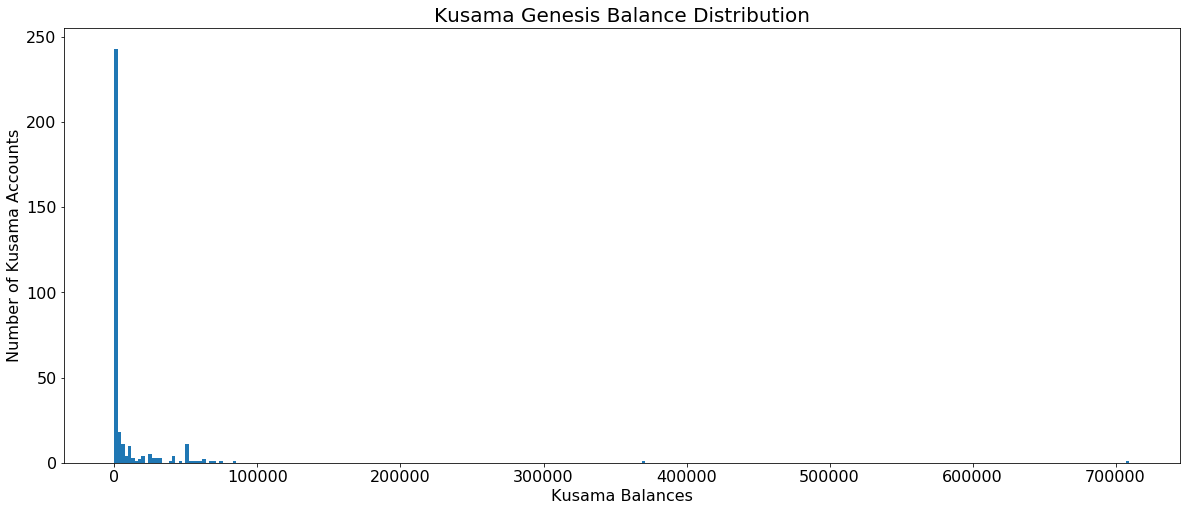

In [6]:
# Histogram of Kusama balances ignoring accounts with <= 0.01 KSM
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('KusamaGenesisBalances.pdf')

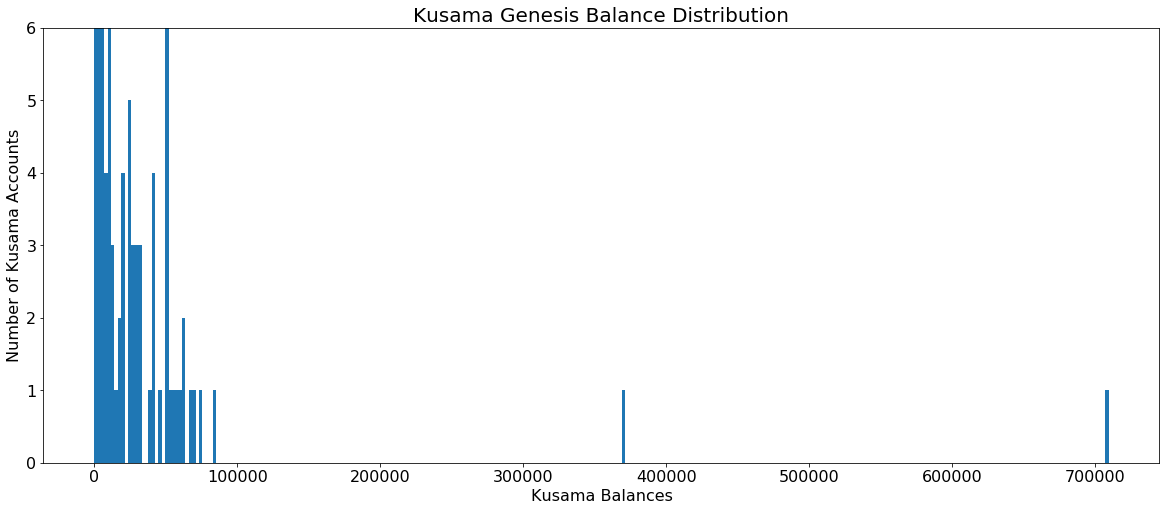

In [7]:
# Zooming into the figure
plt.figure(figsize=(20,8))
plt.hist(dataClean["Balance"],300)
plt.xlabel('Kusama Balances',fontsize = 16)
plt.ylabel('Number of Kusama Accounts',fontsize = 16)
plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,6])
plt.show()

In [8]:
#outlierShare
round((dataClean["Balance"][1]+dataClean["Balance"][2])*100/sumKSM,2)

12.22

We observe two outlier account balances with 709,346.898 & 369,340.969 KSM, whereas the lowest balance has 0.825 KSM. The largest two balances hold 12.22 % share of the whole Kusamas at genesis.

### 1.3. Fitting with Known Distributions

/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


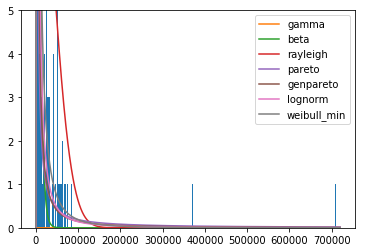

In [9]:
# Testing fitting the pdf of the sample with some known distributions
size = 7.2*10**5
x = sp.arange(size)
y = dataClean["Balance"].values
h = plt.hist(y, 300)

dist_names =['gamma', 'beta','rayleigh', 'pareto', 'genpareto', 'lognorm', 'weibull_min']

for dist_name in dist_names:
    dist = getattr(sp.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.ylim(0,5)
    #plt.xlim(0,)
plt.legend(loc='upper right')
plt.show()

We see that none of the fat tailled distributions capture the outliers well. Hence we will resort to generating samples from the distribution directly.

### 1.4. Bootstraping from the Sample

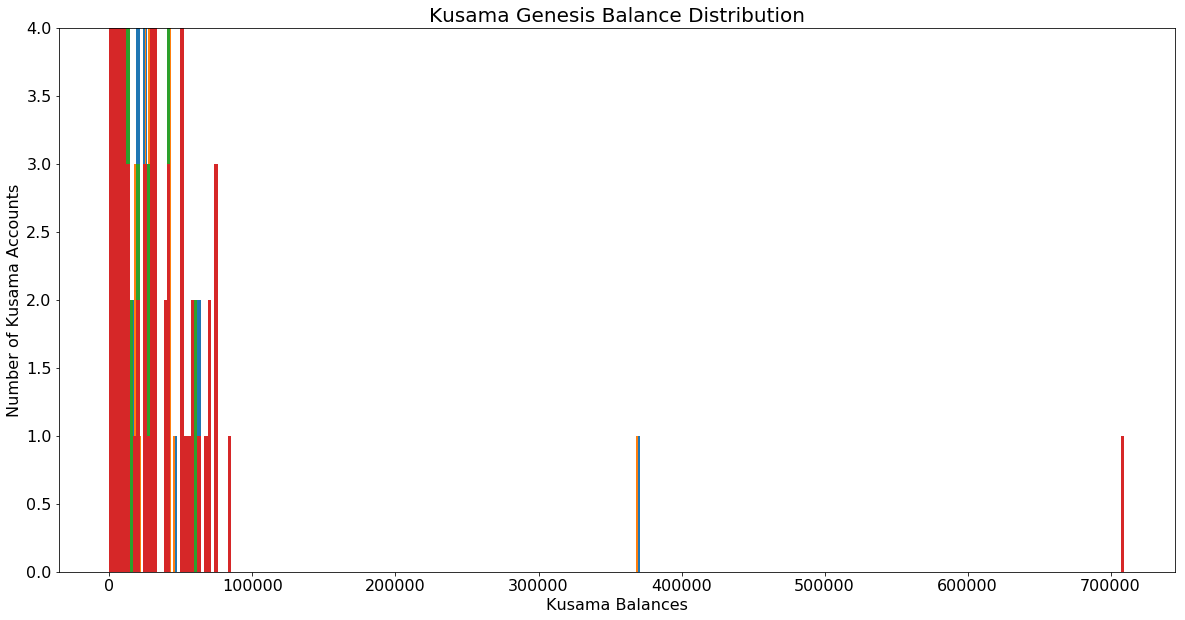

In [10]:
# Testing bootstraping from randomly chosing from the sample
plt.figure(figsize=(20,10))
plt.hist(dataClean["Balance"].values,300)
# Bootstrap sample size --> Test with a few samples
bootstrapSize = 3
bootstrapSample = np.zeros(shape=(dataClean["Balance"].values.size+1,bootstrapSize))
for i in range(bootstrapSize):
    bootstrapSample[0:-1,i] = np.random.choice(dataClean["Balance"].values, size=dataClean["Balance"].values.size, replace=True, p=None)
    plt.hist(bootstrapSample[0:-1,i],300)
    plt.xlabel('Kusama Balances',fontsize = 16)
    plt.ylabel('Number of Kusama Accounts',fontsize = 16)
    plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([0,4])
plt.show()

### 1.5. Empirical Distribution

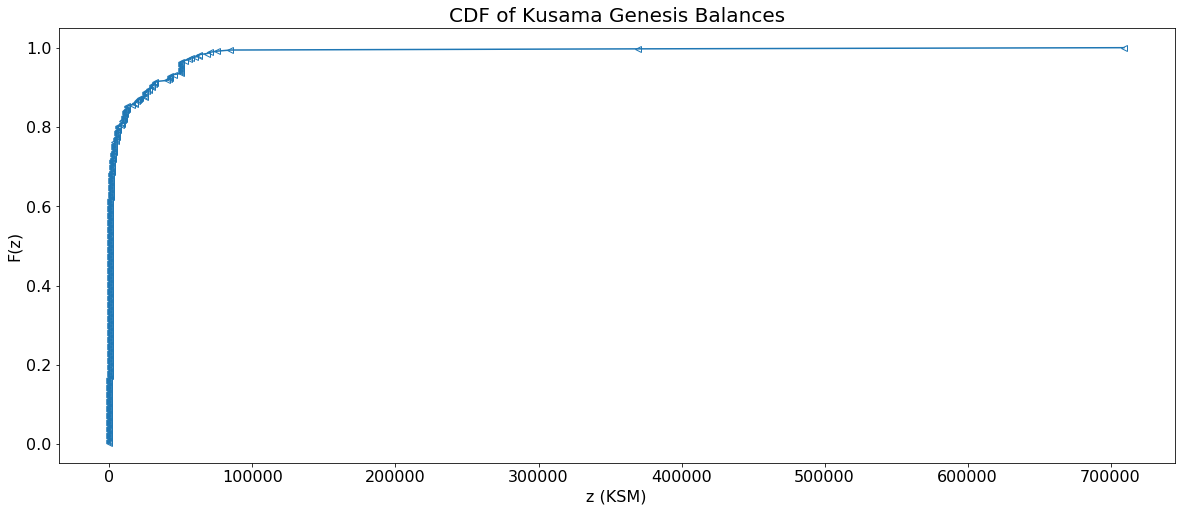

In [11]:
# Empirical cumulative distribution function (cdf) of balances
cdf = ECDF(dataClean["Balance"].values)
plt.figure(figsize=(20,8))
plt.plot(cdf.x, cdf.y ,marker="<", markerfacecolor='none')
plt.xlabel('z (KSM)',fontsize = 16)
plt.ylabel('F(z)',fontsize = 16)
plt.title('CDF of Kusama Genesis Balances',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

**To be done: draw samples from the empirical cdf F(z) to simulate staking.**

# 2. A Statistical Model of Staking, Payouts and Slashing

 **To be discussed before implementation**